In [3]:
# Data Handling & Manipulation
import pandas as pd                                         # for dataframes, CSV/Excel reading, tabular data manipulation
import numpy as np                                          # for numerical operations and array handling

# Data Visualisation (Static)
import matplotlib.pyplot as plt                             # for creating static plots
from matplotlib.ticker import FuncFormatter                 # for customising tick labels (e.g., currency, %)
import seaborn as sns                                       # for statistical visualisation (heatmaps, distplots, etc.)

# Data Visualisation (Interactive)
import plotly.express as px                                 # for quick and interactive visualisation
import plotly.graph_objects as go                           # for custom interactive plots
from plotly.subplots import make_subplots                   # for interactive subplots

# Statistical Testing & Inference
from statsmodels.stats.proportion import proportions_ztest  # for comparing proportions (e.g., late vs. on-time)
from scipy.stats import (
    normaltest,                                             # for checking normality
    chi2_contingency,                                       # for categorical association
    mannwhitneyu,                                           # for non-parametric testing
    ttest_ind,                                              # for independent sample t-test
    f_oneway,                                               # for one-way ANOVA
    kruskal,                                                # for Kruskal-Wallis test
    kstest,                                                 # for Kolmogorov-Smirnov test
    spearmanr                                               # for spearmean correlation
)
import statsmodels.api as sm                                # for advanced statistical modelling and diagnostics
import statsmodels.formula.api as smf                       # for formula-based statistical models
from statsmodels.stats.multicomp import pairwise_tukeyhsd   # for post-hoc tests after ANOVA

# Data Quality & Missing Value Visualisation
import missingno as msno                                    # for visualising missing data patterns

# System & Settings
import os                                                   # for file handling and directory operations
import warnings                                             # to suppress or manage warning messages
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_colwidth', None)                 # display full content in cells (useful for text data)

In [4]:
# List of date columns for each Olist dataset
# This dictionary maps each dataset filename to a list of columns that should be parsed as dates.
date_cols = {
    'olist_orders_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
    ],
    'olist_order_items_dataset.csv': [
        'shipping_limit_date',
    ],
    'olist_order_reviews_dataset.csv': [
        'review_creation_date',
        'review_answer_timestamp',
    ],
    # The following datasets have NO date columns:
    # 'olist_customers_dataset.csv'
    # 'olist_geolocation_dataset.csv'
    # 'olist_order_payments_dataset.csv'
    # 'olist_products_dataset.csv'
    # 'olist_sellers_dataset.csv'
    # 'product_category_name_translation.csv'
    'master_olist_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
        'shipping_limit_date',
        'review_creation_date',
        'review_answer_timestamp',
    ]
}

def read_olist_csv(path):
    """
    Reads an Olist CSV and parses dates for the correct columns.
    Args:
        path (str): Path to the CSV file.
    Returns:
        pd.DataFrame: Loaded dataframe with date columns parsed as datetime.
    """
    # Extract just the filename, e.g., 'olist_orders_dataset.csv'
    filename = os.path.basename(path)
    # Get the correct date columns for this file, or an empty list
    parse_dates = date_cols.get(filename, [])
    # Read the CSV, parsing the specified date columns (if any)
    return pd.read_csv(path, parse_dates=parse_dates)

Load master dataset

In [5]:
master_olist_dataset = read_olist_csv('../data/cleaned_data/master_olist_dataset.csv')

In [6]:
master_olist_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115093 entries, 0 to 115092
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115093 non-null  object        
 1   customer_id                    115093 non-null  object        
 2   order_status                   115093 non-null  object        
 3   order_purchase_timestamp       115093 non-null  datetime64[ns]
 4   order_approved_at              115093 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115093 non-null  datetime64[ns]
 6   order_delivered_customer_date  115093 non-null  datetime64[ns]
 7   order_estimated_delivery_date  115093 non-null  datetime64[ns]
 8   customer_unique_id             115093 non-null  object        
 9   customer_zip_code_prefix       115093 non-null  int64         
 10  customer_city                  115093 non-null  object        
 11  

In [9]:
master_olist_ml_df = master_olist_dataset.copy()

In [10]:
master_olist_ml_df['is_late']    = master_olist_dataset['order_delivered_customer_date'] > master_olist_dataset['order_estimated_delivery_date']

Drop unused features

In [11]:
features_after_approval = [
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'review_id',
    'review_score',
    'review_comment_title',
    'review_comment_message',
    'review_creation_date',
    'review_answer_timestamp',
    'has_review',
]

In [12]:
master_olist_ml_df = master_olist_ml_df.drop(columns=features_after_approval)

master_olist_ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115093 entries, 0 to 115092
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115093 non-null  object        
 1   customer_id                    115093 non-null  object        
 2   order_status                   115093 non-null  object        
 3   order_purchase_timestamp       115093 non-null  datetime64[ns]
 4   order_approved_at              115093 non-null  datetime64[ns]
 5   order_estimated_delivery_date  115093 non-null  datetime64[ns]
 6   customer_unique_id             115093 non-null  object        
 7   customer_zip_code_prefix       115093 non-null  int64         
 8   customer_city                  115093 non-null  object        
 9   customer_state                 115093 non-null  object        
 10  order_item_id                  115093 non-null  float64       
 11  

# Features Creation

## Geographical Features

In [13]:
cleaned_df_geolocation      = read_olist_csv('../data/cleaned_data/olist_geolocation_dataset.csv')

### Add aggregated lat & lng pair for both customers & sellers

In [14]:
# Merge location data
# Get median geo coordinates for each zip code
median_coords = cleaned_df_geolocation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'median',
    'geolocation_lng': 'median'
}).reset_index()

# Merge customer geo data
master_olist_ml_df = master_olist_ml_df.merge(
    median_coords,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
).rename(columns={
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng'
})

# Merge seller geo data 
master_olist_ml_df = master_olist_ml_df.merge(
    median_coords,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left',
    suffixes=('_drop', '')
).rename(columns={
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng'
})

# Drop redundant columns
master_olist_ml_df = master_olist_ml_df.drop(columns=['geolocation_zip_code_prefix', 'geolocation_zip_code_prefix_drop'], errors='ignore')
master_olist_ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115093 entries, 0 to 115092
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115093 non-null  object        
 1   customer_id                    115093 non-null  object        
 2   order_status                   115093 non-null  object        
 3   order_purchase_timestamp       115093 non-null  datetime64[ns]
 4   order_approved_at              115093 non-null  datetime64[ns]
 5   order_estimated_delivery_date  115093 non-null  datetime64[ns]
 6   customer_unique_id             115093 non-null  object        
 7   customer_zip_code_prefix       115093 non-null  int64         
 8   customer_city                  115093 non-null  object        
 9   customer_state                 115093 non-null  object        
 10  order_item_id                  115093 non-null  float64       
 11  

#### Handle missing lat/lng

The missing lat & lng are due to customer/seller having a zip_code_prefix that doesn't exists in the geolocation dataset

In [ ]:
# Check missing percentage for customer and seller coordinates
missing_coords = {
    'customer_lat': (master_olist_ml_df['customer_lat'].isna().sum() / len(master_olist_ml_df)) * 100,
    'customer_lng': (master_olist_ml_df['customer_lng'].isna().sum() / len(master_olist_ml_df)) * 100,
    'seller_lat': (master_olist_ml_df['seller_lat'].isna().sum() / len(master_olist_ml_df)) * 100,
    'seller_lng': (master_olist_ml_df['seller_lng'].isna().sum() / len(master_olist_ml_df)) * 100
}

# Create a DataFrame to display the missing percentages
missing_coords_df = pd.DataFrame({
    'Column': list(missing_coords.keys()),
    'Missing %': list(missing_coords.values())
})

# Calculate the number of rows with any missing coordinate
rows_with_missing = master_olist_ml_df[
    master_olist_ml_df['customer_lat'].isna() | 
    master_olist_ml_df['customer_lng'].isna() | 
    master_olist_ml_df['seller_lat'].isna() | 
    master_olist_ml_df['seller_lng'].isna()
].shape[0]

# Calculate percentage of rows with any missing coordinate
pct_rows_with_missing = (rows_with_missing / len(master_olist_ml_df)) * 100

# Display results
print(missing_coords_df)
print(f"\nRows with any missing coordinate: {rows_with_missing} ({pct_rows_with_missing:.2f}%)")

         Column  Missing %
0  customer_lat   0.261528
1  customer_lng   0.261528
2    seller_lat   0.225035
3    seller_lng   0.225035

Rows with any missing coordinate: 559 (0.49%)


In [22]:
# overall share of orders by state
overall_customer = (master_olist_ml_df['customer_state']
           .value_counts(normalize=True)
           .rename('overall_customer_prop'))

overall_seller = (master_olist_ml_df['seller_state']
          .value_counts(normalize=True)
          .rename('overall_seller_prop'))

# Create masks for missing coordinates
missing_customer_mask = master_olist_ml_df['customer_lat'].isna()
missing_seller_mask = master_olist_ml_df['seller_lat'].isna()

# Calculate proportion for missing customer coordinates by state
missing_customer_prop = (master_olist_ml_df.loc[missing_customer_mask, 'customer_state']
                .value_counts(normalize=True)
                .rename('missing_customer_prop'))

# Calculate proportion for missing seller coordinates by state
missing_seller_prop = (master_olist_ml_df.loc[missing_seller_mask, 'seller_state']
                .value_counts(normalize=True)
                .rename('missing_seller_prop'))

# Create a dataframe for customer bias analysis
customer_bias = (pd.concat([overall_customer, missing_customer_prop], axis=1)
                .fillna(0)
                .assign(customer_lift=lambda d: d['missing_customer_prop'] / d['overall_customer_prop']))

# Create a dataframe for seller bias analysis
seller_bias = (pd.concat([overall_seller, missing_seller_prop], axis=1)
                .fillna(0)
                .assign(seller_lift=lambda d: d['missing_seller_prop'] / d['overall_seller_prop']))

# Show the top 10 states with highest lift for customers
display(customer_bias.sort_values('customer_lift', ascending=False))

display(seller_bias.sort_values('seller_lift', ascending=False))

,overall_customer_prop,missing_customer_prop,customer_lift
customer_state,,,
DF,0.021113,0.617940,29.267733
RO,0.002442,0.006645,2.721486
PI,0.004770,0.009967,2.089447
CE,0.013033,0.026578,2.039300
GO,0.020653,0.029900,1.447757
MA,0.007099,0.009967,1.404047
RN,0.004883,0.006645,1.360743
PB,0.005422,0.006645,1.225541
BA,0.034181,0.039867,1.166351


,overall_seller_prop,missing_seller_prop,seller_lift
seller_state,,,
DF,0.008080,0.158301,19.590705
MG,0.078354,0.258687,3.301518
SP,0.713440,0.552124,0.773889
RS,0.019541,0.007722,0.395175
PR,0.076599,0.023166,0.302433
CE,0.000860,0.000000,0.000000
PA,0.000070,0.000000,0.000000
SE,0.000087,0.000000,0.000000
PI,0.000096,0.000000,0.000000


Only 0.5 % of orders lacked ZIP-level coordinates. Because 62 % of these came from Brasília (a compact metro area), we imputed missing lat/lng with the median of all geolocation points in the same state and flagged those rows. This retains all data while avoiding external APIs and introducing no target leakage.

- Only 0.26 % of customers and 0.23 % of sellers lack coordinates.
- \> 60 % of those gaps are in DF (Brasília)—a single, geographically small metro area.
- Remaining gaps are scattered, each contributing ≪ 0.05 % of total rows.	
- A single median point for DF is basically a city centroid (< 15 km error)—more precise than the entire state centroid would be in SP or MG.
- Errors elsewhere (SP, MG, etc.) affect < 0.1 % of rows, so any blurring is statistically negligible.

In [24]:
# build once
state_centroids = (cleaned_df_geolocation
                   .groupby('geolocation_state', as_index=False)
                   .agg(state_lat=('geolocation_lat', 'median'),
                        state_lng=('geolocation_lng', 'median')))

def impute_state_centroid(df, role):
    df = df.merge(state_centroids,
                  left_on=f'{role}_state',
                  right_on='geolocation_state',
                  how='left')
    mask = df[f'{role}_lat'].isna()
    df.loc[mask, f'{role}_lat'] = df.loc[mask, 'state_lat']
    df.loc[mask, f'{role}_lng'] = df.loc[mask, 'state_lng']
    df[f'{role}_coord_imputed'] = mask          # flag uncertainty
    return df.drop(columns=['state_lat', 'state_lng', 'geolocation_state'])

master_olist_ml_df = impute_state_centroid(master_olist_ml_df, 'customer')
master_olist_ml_df = impute_state_centroid(master_olist_ml_df, 'seller')

master_olist_ml_df = master_olist_ml_df.drop(columns=['customer_coord_imputed', 'seller_coord_imputed'], errors='ignore')

master_olist_ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115093 entries, 0 to 115092
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115093 non-null  object        
 1   customer_id                    115093 non-null  object        
 2   order_status                   115093 non-null  object        
 3   order_purchase_timestamp       115093 non-null  datetime64[ns]
 4   order_approved_at              115093 non-null  datetime64[ns]
 5   order_estimated_delivery_date  115093 non-null  datetime64[ns]
 6   customer_unique_id             115093 non-null  object        
 7   customer_zip_code_prefix       115093 non-null  int64         
 8   customer_city                  115093 non-null  object        
 9   customer_state                 115093 non-null  object        
 10  order_item_id                  115093 non-null  float64       
 11  

### Add customer-seller distance using Haversine Distance (kilometers)

In [25]:
# Calculate distance between customer and seller
# Using Haversine formula to calculate distance between two coordinates
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Apply the formula to calculate distance for all rows with valid coordinates
mask = (~master_olist_ml_df['customer_lat'].isna()) & (~master_olist_ml_df['seller_lat'].isna())
master_olist_ml_df.loc[mask, 'distance_km'] = haversine(
    master_olist_ml_df.loc[mask, 'customer_lat'],
    master_olist_ml_df.loc[mask, 'customer_lng'],
    master_olist_ml_df.loc[mask, 'seller_lat'],
    master_olist_ml_df.loc[mask, 'seller_lng']
)

# Print summary statistics of the new distance feature
print(f"Distance statistics (km):")
print(f"Mean: {master_olist_ml_df['distance_km'].mean():.2f}")
print(f"Median: {master_olist_ml_df['distance_km'].median():.2f}")
print(f"Min: {master_olist_ml_df['distance_km'].min():.2f}")
print(f"Max: {master_olist_ml_df['distance_km'].max():.2f}")
print(f"Null values: {master_olist_ml_df['distance_km'].isna().sum()}")

Distance statistics (km):
Mean: 597.16
Median: 433.64
Min: 0.00
Max: 3398.55
Null values: 0


### Same-state vs Inter-state delivery

In [27]:
# same_state
master_olist_ml_df["same_state"] = (master_olist_ml_df["customer_state"] == master_olist_ml_df["seller_state"]).astype(int)

In [29]:
master_olist_ml_df[['customer_state', 'seller_state', 'same_state']].head(10)

,customer_state,seller_state,same_state
0,SP,SP,1
1,SP,SP,1
2,SP,SP,1
3,BA,SP,0
4,GO,SP,0
5,RN,MG,0
6,SP,SP,1
7,PR,SP,0
8,RJ,SP,0
9,RS,SP,0


#### Quick analysis of the feature

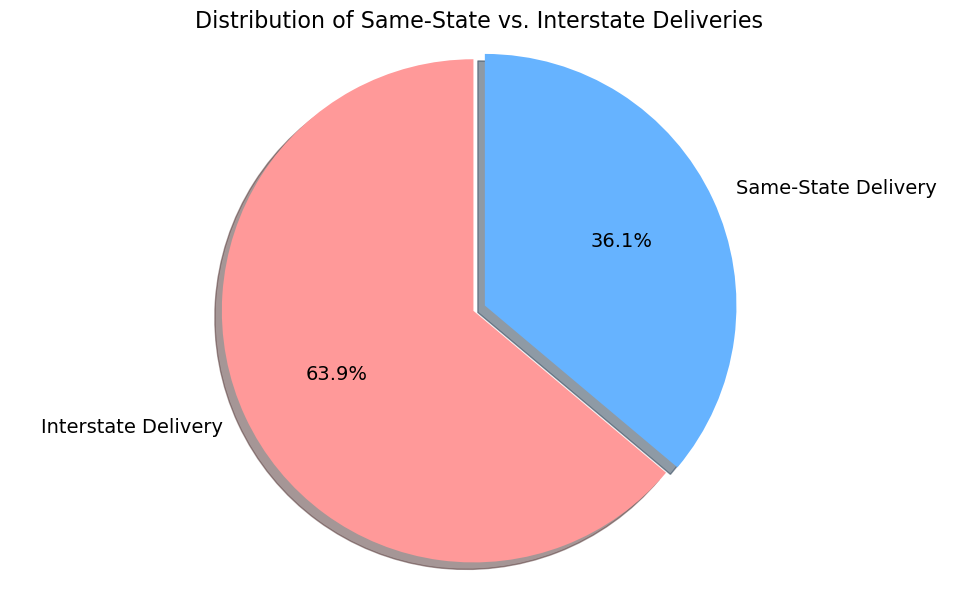

Interstate deliveries: 73516 (63.9%)
Same-state deliveries: 41577 (36.1%)


In [30]:
# Create a pie chart for same_state distribution
plt.figure(figsize=(10, 6))
labels = ['Interstate Delivery', 'Same-State Delivery']
sizes = master_olist_ml_df['same_state'].value_counts().sort_index()
colors = ['#ff9999','#66b3ff']
explode = (0.05, 0)  # explode the 1st slice for emphasis

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
    shadow=True, startangle=90, textprops={'fontsize': 14})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.title('Distribution of Same-State vs. Interstate Deliveries', fontsize=16)
plt.tight_layout()
plt.show()

# Add a text summary
interstate_pct = sizes[0] / sizes.sum() * 100
same_state_pct = sizes[1] / sizes.sum() * 100
print(f"Interstate deliveries: {sizes[0]} ({interstate_pct:.1f}%)")
print(f"Same-state deliveries: {sizes[1]} ({same_state_pct:.1f}%)")

**Is being an interstate shipment (seller ≠ customer state) associated with a different late-delivery rate than shipments that stay inside the same state?**

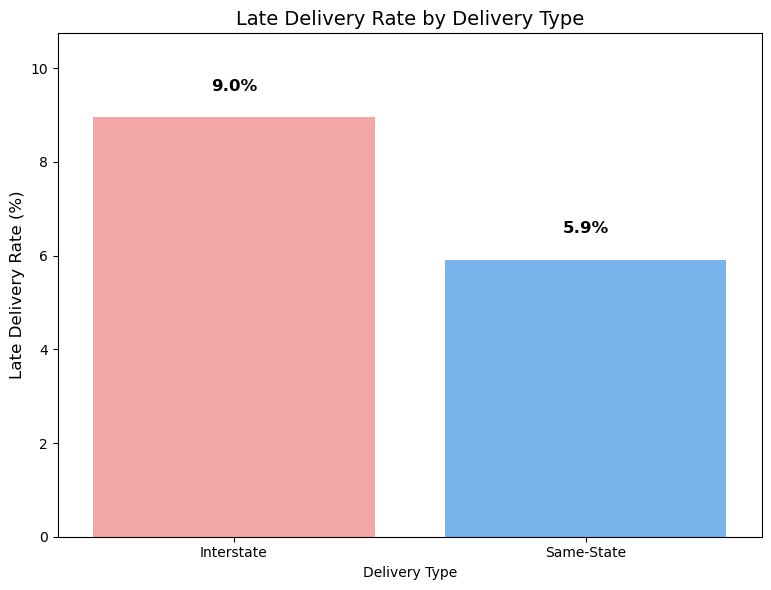

Chi-square statistic: 338.39
p-value: 0.0000000000
Degrees of freedom: 1

Conclusion: There is a statistically significant relationship between delivery type and late delivery rate (p < 0.05).
Effect size (Cramer's V): 0.0542 (negligible association)
Odds ratio: 1.56
Interstate deliveries are 1.56x more likely to be late than same-state deliveries.


In [32]:
# 1. Create a contingency table for statistical analysis
contingency = pd.crosstab(master_olist_ml_df['same_state'], master_olist_ml_df['is_late'])

# 2. Calculate late rates by delivery type
late_rates = pd.DataFrame({
    'Delivery Type': ['Interstate', 'Same-State'],
    'Count': [contingency.loc[0].sum(), contingency.loc[1].sum()],
    'Late Count': [contingency.loc[0, True], contingency.loc[1, True]],
})
late_rates['Late Rate'] = late_rates['Late Count'] / late_rates['Count'] * 100
late_rates['On-time Count'] = late_rates['Count'] - late_rates['Late Count']

# 3. Run a chi-square test to check for statistical significance
chi2, p_value, dof, expected = chi2_contingency(contingency)

# 4. Create visualizations to illustrate the relationship
plt.figure(figsize=(15, 6))

# 4.1 Side-by-side bar chart comparing late rates
plt.subplot(1, 2, 1)
sns.barplot(x='Delivery Type', y='Late Rate', data=late_rates, palette=['#ff9999', '#66b3ff'])
plt.title('Late Delivery Rate by Delivery Type', fontsize=14)
plt.ylabel('Late Delivery Rate (%)', fontsize=12)
plt.ylim(0, max(late_rates['Late Rate']) * 1.2)  # Add some headroom

# Add actual percentages as text labels
for i, row in late_rates.iterrows():
    plt.text(i, row['Late Rate'] + 0.5, f"{row['Late Rate']:.1f}%", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Print statistical analysis summary
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.10f}")
print(f"Degrees of freedom: {dof}")

# Helper function for interpreting Cramer's V
def interpret_cramers_v(v):
    if v < 0.1:
        return "negligible association"
    elif v < 0.2:
        return "weak association"
    elif v < 0.3:
        return "moderate association"
    elif v < 0.4:
        return "relatively strong association"
    else:
        return "strong association"

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print(f"\nConclusion: There is a statistically significant relationship between delivery type and late delivery rate (p < {alpha}).")
    
    # Calculate the strength of the relationship (Cramer's V)
    n = contingency.sum().sum()
    cramer_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
    print(f"Effect size (Cramer's V): {cramer_v:.4f} ({interpret_cramers_v(cramer_v)})")
    
    # Calculate odds ratio for interpretability
    odds_ratio = (contingency.loc[0, True] / contingency.loc[0, False]) / (contingency.loc[1, True] / contingency.loc[1, False])
    print(f"Odds ratio: {odds_ratio:.2f}")
    print(f"Interstate deliveries are {odds_ratio:.2f}x more likely to be late than same-state deliveries.")
else:
    print(f"\nConclusion: There is NO statistically significant relationship between delivery type and late delivery rate (p > {alpha}).")

**Interpretation**

| Metric                       | Value                      | Rule-of-thumb interpretation                                        |
| ---------------------------- | -------------------------- | ------------------------------------------------------------------- |
| **Absolute risk difference** | 9.0 % − 5.9 % = **3.1 pp** | 3 extra late orders per 100 when the shipment crosses a state line. |
| **Odds ratio**               | **1.56**                   | The *odds* of being late rise 56 % for interstate vs. same-state.   |
| **Cramér’s V**               | **0.054**                  | “Negligible” by textbook cut-offs (< 0.10).                         |

Why the contrast?
Because there are 100k+ orders. With that much data, even a small percentage-point gap drives a huge χ² statistic. Cramér's V scales the χ² by sample size, so it flags that the association, while real, is not especially strong relative to all the variation in lateness.

Interstate shipments have a 9.0 % late rate vs. 5.9 % for same-state (χ² = 338, p < 10⁻¹⁰).
The odds of a late arrival rise 56 % when a parcel crosses a state line, but the overall effect size is small (Cramér’s V = 0.05). Distance and other logistics factors likely drive most of the lateness variance, so we will include same_state as a supporting feature rather than a primary focus.

In [ ]:
# Create freight_ratio first
df["freight_ratio"] = df["freight_value"] / df["price"].clip(lower=1)
# 75th percentile distance, 95th percentile freight ratio
remote_dist_thr  = df["geo_distance_km"].quantile(0.75)
remote_freight_thr = df["freight_ratio"].quantile(0.95)
df["customer_is_remote"] = (
    (df["geo_distance_km"] > remote_dist_thr) |
    (df["freight_ratio"] > remote_freight_thr)
).astype(int)

# 2. seller_dispatch_hub (seller’s % of orders going out-of-state)
seller_home_state = df.groupby("seller_id")["seller_state"].first()
df = df.merge(seller_home_state.rename("seller_home_state"), on="seller_id", how="left")
df["is_outside_home"] = (df["customer_state"] != df["seller_home_state"]).astype(int)
seller_hub_score = (
    df.groupby("seller_id")["is_outside_home"]
    .agg(["sum", "count"])
    .assign(hub_score=lambda x: (x["sum"] + 2) / (x["count"] + 4))  # Laplace smoothing
)["hub_score"]
df["seller_dispatch_hub"] = df["seller_id"].map(seller_hub_score)

# 3. product_volume_cm3
dims = ["product_length_cm", "product_height_cm", "product_width_cm"]
df["product_volume_cm3"] = df[dims].prod(axis=1)

# 4. density_g_per_cm3
df["density_g_per_cm3"] = df["product_weight_g"] / df["product_volume_cm3"].clip(lower=1)

# 5. oversize_flag, overweight_flag (90th percentile in train only if possible)
vol_cut = df["product_volume_cm3"].quantile(0.90)
wgt_cut = df["product_weight_g"].quantile(0.90)
df["oversize_flag"] = (df["product_volume_cm3"] > vol_cut).astype(int)
df["overweight_flag"] = (df["product_weight_g"] > wgt_cut).astype(int)

# 6. inter_region (optional, for ablation)
# Define a mapping from state to macro-region (Brazilian standard)
brazil_region_map = {
    'AC':'North','AL':'Northeast','AP':'North','AM':'North','BA':'Northeast','CE':'Northeast',
    'DF':'Central-West','ES':'Southeast','GO':'Central-West','MA':'Northeast','MT':'Central-West',
    'MS':'Central-West','MG':'Southeast','PA':'North','PB':'Northeast','PR':'South','PE':'Northeast',
    'PI':'Northeast','RJ':'Southeast','RN':'Northeast','RS':'South','RO':'North','RR':'North',
    'SC':'South','SP':'Southeast','SE':'Northeast','TO':'North'
}
df["customer_region"] = df["customer_state"].map(brazil_region_map)
df["seller_region"]   = df["seller_state"].map(brazil_region_map)
df["inter_region"]    = (df["customer_region"] != df["seller_region"]).astype(int)

# --------- 3. CANCELLED FEATURES ---------
# product_category_name (PT): Drop – redundant with English version
# fragile_flag: Skip – high effort, low expected value
# price_per_item: Drop – at item level, it's just price

# --------- 4. CLEANUP AND FINAL FEATURE SET ---------
# List of all sure-fire and candidate columns for modeling
surefire_cols = [
    "customer_state", "seller_state", "geo_distance_km", "log_distance", "same_state",
    "freight_value", "price", "product_category_name_english"
]
candidate_cols = [
    "customer_is_remote", "seller_dispatch_hub", "product_volume_cm3", "density_g_per_cm3",
    "oversize_flag", "overweight_flag", "freight_ratio", "inter_region"
]

# OPTIONAL: drop intermediate/merge columns if not needed
df.drop(columns=["seller_home_state", "is_outside_home", "customer_region", "seller_region"], inplace=True, errors='ignore')

# Now you can select your feature set for modeling:
feature_cols = surefire_cols + candidate_cols

# Example: 
X = df[feature_cols]
